In [ ]:
### VPG is a modified version of the Reinforce algorithm, in this a baseline is introduced, which calculates the average
### expected return for a state: i.e, we consider the expected rewards from all the actions on the state.

### So, baseline b = E(Gt|St) = b(St)

### In case of reinforce algorithm, we multiplied Gt with the log(P[a|s]) to calculate gradient. As Gt is collected from
### sample real ground walks, return Gt has very high variance. Also, as return for every action, Gi for action i is greater
### than 0, during gradient ascent, the P[a1|s]........ P[an|s] i.e, all the probabilities for all the action on that state,
### increases, though the action with the more return dominates. This creates a duality, that in turn reduces the 
### sample efficiency.  

### In case of VPG, the multiplication of Gt to the gradient ascent is replaced using Gt-b(St) 
### where b(St) = E(Gt|St)-> Expected sum of rewards on state St, considering all action

### Replacement of Gt by A(st) = Gt-b(St) solves two problem, 

### 1. As we substract the b(St) from the return Gt, the variance is decreased 
### 2. As we substract Gt-b(St), calculated as Advantage, Advantage At=Gt - b(St), the value of the Advantage is 
### always not positive, We get At both positive and negative instead of Gt which was always positive.


### As b(st) is the value function of the state, that is a generalized expected sum of rewards, only those actions, that
### can increase the reward give positive value for the action. The definition becomes, how better an action, performs on a
### state compared to all other action on the state,

### So, in this case, for only those actions whose advantage is positive the P[a|s] is maximized, else the probability P[a|s] is minimized. 
### For which it is mmaximum, that action dominates.



In [ ]:
### The above reason increases its sample efficiency

In [ ]:
### In VPG, we have 2 models, one of them is the agent, that predicts the probability distribution of all 
### actions on the state s. while the other is the baseline model.

### The baseline model predicts the value of b(St), for a state. 

### VPG provides an unbiased estimate, and we do not use Gt directly, so the variance is low.



In [ ]:
### The baseline model uses gradient descent and tries to minimize the MSE between, b(St) and Gt

### Minimize |b(St) - Gt|^2 

In [ ]:
### The agent model similar to reinforce algorithm, maximizes the Value function for the paramtered policy
### So, it uses gradient ascent W = W + lr* dV(w)/dw

### where the update is:

In [ ]:
import matplotlib.pyplot as plt
import cv2

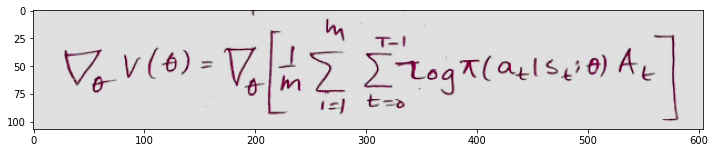

In [ ]:
image=cv2.imread("VPG_eqn.png")
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

### Cartpole problem

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [ ]:
import gym

In [ ]:
env=gym.make('CartPole-v0')
env._max_episode_steps=200

In [ ]:
class VPG:

  def __init__(self,env):
    self.env=env
    self.state_dimension=env.observation_space.shape   ### Input state dimension
    self.no_of_action=env.action_space.n              ### No of actions
    self.agent=None      ### the learner 
    self.baseline=None   ### baseline model
    self.agent_opt=tf.keras.optimizers.Adam(learning_rate=0.0003)
    self.goal=200
    self.m=300
  
  def get_baseline(self):
    
    input_layer=tf.keras.layers.Input(self.state_dimension)  ### Takes the state for which we want to 
    ### predict the baseline as input

    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)
    
    output_layer=tf.keras.layers.Dense(1)(layer_3)  ### Predicts the baseline for that state.

    model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer])
    model.compile(loss="mse",optimizer="adam")  ## Minimizes the MSE between Gt and Baseline b(St)
    
    return model
  
  def get_agent(self):

    input_layer=tf.keras.layers.Input(self.state_dimension) ### Takes the state as input
    ### for which the agent has to predict the probability distribution of the actions.

    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)
    
    output_layer=tf.keras.layers.Dense(self.no_of_action, activation="softmax")(layer_3)

    ### Predicts the peobability of all the actions on the state s, so the number of nodes in
    ### the final layer of model is equal to the number of actions 
    ### and we generate a probabilistic distribution so softmax is used as the activation function.
    
    model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer])
    
    return model

  def action(self,s):
    s=s.reshape(1,-1)
    ### Reshaping to obtain the probability of action for a single state:
    ### [0.5, 0.4, 0.2, 0.1] -> [[0.5, 0.4, 0.2, 0.1]]
    out=self.agent(s)
    action_prob=tfp.distributions.Categorical(probs=out)
    action= action_prob.sample()
    ### sampling an action from the obtained probability distributions for all the actions
    return action.numpy()[0]  ### Action returned as 1D tensor-> converting to scalar

  def log_prob(self,s,a):
    out=self.agent(s)
    ### again to be used in batch
    action_prob=tfp.distributions.Categorical(probs=out)
    ### takes in the states and the actions and returns the corresponding log probability 
    ### of the occurence of the taken action a on the state s
    ### log(P[a|s : w]) is obtained.
    
    return action_prob.log_prob(a)

  def loss(self,S,A,Adv):
    ### S is the state vector for the batch of size "m"
    ### A is the action vector for the batch of size "m"
    ### Adv is the advantage vector for the batch of size "m"

    m=S.shape[0] ### batch size
    log_pi_A_given_S=self.log_prob(S,A)  ### Obtaining log(Pi[a|s :w])
    #### log probability of the occurence of the taken action a on the state s

    #### Creating the loss function as given in the image above
    ### loss= (1/m)*(log(Pi[a|s :w]).Adv)
    ### as we need gradient ascent we multiply with -1
    return -1*tf.reduce_sum(tf.multiply(log_pi_A_given_S,Adv))/self.m

  def get_episodes(self):
    ### To sample raw walks in the environment
    states=[]
    actions=[]
    rewards=[]

    curr_state=self.env.reset()
    done=False

    while not done:
      action=self.action(curr_state)
      next_state,reward,done,_=self.env.step(action)
      ### Obtaining next step.

      states.append(curr_state)
      actions.append(action)
      rewards.append(reward)
      ### logging the essential required values for loss estimation

      curr_state=next_state ### Updating.

    return states,actions,rewards  ### All logs returned

  def get_returns(self,rewards,gamma=0.99):
    G=[] ## to log the returns for each state.
    ret=0
    for r in reversed(rewards):
      #### as we collect the rewards using forward propagation, and to calculate returns we 
      ### should backpropagate, so reversing the rewards array.
      ret= r + gamma*ret ### calculating return.
      G.insert(0,ret) ## we have reversed the reward array so, we are moving from back to front,
      ### So, we always insert in the front, as the fist element, which actually corresponds to
      ### the last step, moves back.
    
    return np.array(G)
  
  def get_experience(self,m):
    ### Get experience on the full batch :multiple sample
    states=[]
    actions=[]
    G=[]
    V=0
    for i in range(m):
      S,A,R=self.get_episodes()
      g=self.get_returns(R) 
      R=sum(R)
      ### For each episode in number of samples, collecting experience
      states.extend(S)
      actions.extend(A)
      G.extend(g)
      V+=R
      #### logging the stats of the ith sampling 
      ### "extend" not "append", as we want to create only one total set of episodes
    
    return np.array(states),np.array(actions),np.array(G),V/m

  def train(self):
    curr_v=0
    target_v=self.goal
    self.agent=self.get_agent()
    self.baseline=self.get_baseline()

    i=1
    while curr_v<target_v:
      
      ### In this case for each m trajectory samples, we need to update the baseline model
      ### for each update of the agent
      
      S,A,G,curr_v=self.get_experience(self.m)
      print(f"Sample {i}: V: {curr_v}")

      Adv= G - self.baseline.predict(S)
      ### Adv(St) = Gt - b(St)
      ### b(St) is predicted by the baseline model.

      ### Before we use Adv in the model, we need to normalize the advantage values in order to 
      ### reduce the variance in the advantage values further more.
      ### This makes the optimization smoother and increases sample efficiency.

      Adv=(Adv-Adv.mean())/Adv.std() ### standard scaling ### Normalization

      self.baseline.fit(S,G,epochs=100,verbose=0)
      ### Updating the baseline model weights.
      ### Passed the states, and the corresponding return values (Gt).
      ### minimizes |Gt - b(St)|^2

      with tf.GradientTape() as t:
        J=self.loss(S,A,Adv)
      
      grads=t.gradient(J,self.agent.trainable_variables)
      self.agent_opt.apply_gradients(zip(grads,self.agent.trainable_variables))

      i+=1


  

In [ ]:
agent=VPG(env)

In [ ]:
agent.train()

Sample 1: V: 22.84
Sample 2: V: 22.526666666666667
Sample 3: V: 22.886666666666667
Sample 4: V: 24.973333333333333
Sample 5: V: 24.643333333333334
Sample 6: V: 25.063333333333333
Sample 7: V: 24.01
Sample 8: V: 25.303333333333335
Sample 9: V: 27.486666666666668
Sample 10: V: 27.416666666666668
Sample 11: V: 26.866666666666667
Sample 12: V: 28.35
Sample 13: V: 28.053333333333335
Sample 14: V: 31.106666666666666
Sample 15: V: 30.46
Sample 16: V: 31.866666666666667
Sample 17: V: 31.206666666666667
Sample 18: V: 33.22666666666667
Sample 19: V: 31.62
Sample 20: V: 33.11666666666667
Sample 21: V: 33.39
Sample 22: V: 35.47
Sample 23: V: 35.93333333333333
Sample 24: V: 35.55
Sample 25: V: 38.11666666666667
Sample 26: V: 39.4
Sample 27: V: 39.6
Sample 28: V: 40.57333333333333
Sample 29: V: 41.99
Sample 30: V: 45.27
Sample 31: V: 45.083333333333336
Sample 32: V: 46.20333333333333
Sample 33: V: 49.156666666666666
Sample 34: V: 50.916666666666664
Sample 35: V: 54.663333333333334
Sample 36: V: 53.7